In [1]:
import nltk
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from torch.utils.data import DataLoader, Dataset
from RNN import CustomLSTM
from Pytorch_utils import SaveBestModel, LrScheduler, EarlyStopping
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib as mpl


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
df = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")
df.head(10)

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
5,3,"Stocks End Up, But Near Year Lows (Reuters)",Reuters - Stocks ended slightly higher on Frid...
6,3,Money Funds Fell in Latest Week (AP),AP - Assets of the nation's retail money marke...
7,3,Fed minutes show dissent over inflation (USATO...,USATODAY.com - Retail sales bounced back a bit...
8,3,Safety Net (Forbes.com),Forbes.com - After earning a PH.D. in Sociolog...
9,3,Wall St. Bears Claw Back Into the Black,"NEW YORK (Reuters) - Short-sellers, Wall Stre..."


In [3]:
class CleanText:
    
    def __init__(self):
        super().__init__()
        self.regex_html = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
        self.remove_digits = str.maketrans('', '', string.digits + string.punctuation)
        
        
    def __call__(self, text):
        text = re.sub(self.regex_html, '', text)
        text = text.translate(self.remove_digits)
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text).split()).lower()

In [4]:
clean_text = CleanText()
df['Text'] = (df.Title + " " + df.Description).apply(clean_text)
df.drop(['Title', 'Description'], axis=1, inplace=True)
le = LabelEncoder().fit(df['Class Index'])
df['label'] = le.transform(df['Class Index'])

In [5]:
train, val = train_test_split(df, test_size=0.2, random_state=42, stratify=df.label)

In [6]:
print(train.shape, val.shape)

(96000, 3) (24000, 3)


In [7]:
class Vocabulary:
    
    def __init__(self, frequency_threshold):
        self.frequency_threshold = frequency_threshold
        self.tokens_to_idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx_to_tokens = {v:k for k,v in self.tokens_to_idx.items()}
        assert len(self.tokens_to_idx) == len(self.idx_to_tokens)
        
    
    def __len__(self):
        return len(self.tokens_to_id)
    
    def build_vocabulary(self, text):
        frequencies = {}
        idx = 2
        for sent in text:
            tokenized_sent = word_tokenize(sent)
            for word in tokenized_sent:
                if word in frequencies:
                    frequencies[word] += 1
                else:
                    frequencies[word] = 0
        # limit vocabulary by removing lower frequency words
        frequencies = {k:v for k, v in frequencies.items() if v > self.frequency_threshold}
        
        for word, freq in frequencies.items():
            self.tokens_to_idx[word] = idx
            self.idx_to_tokens[idx] = word
            idx += 1
            
    def numeralize(self, sent):
        tokenized_sent = word_tokenize(sent)
        numeralized_sent = []
        for word in tokenized_sent:
            if word in self.tokens_to_idx.keys():
                numeralized_sent.append(self.tokens_to_idx[word])
            else:
                numeralized_sent.append(self.tokens_to_idx['<UNK>'])
        return numeralized_sent

In [8]:
vocab = Vocabulary(4)
vocab.build_vocabulary(train.Text.values)

In [9]:
class SpamClassificationDataset(Dataset):
    
    def __init__(self, dataframe):
        super().__init__()
        self.X, self.Y = dataframe.Text.values, dataframe['label'].values
        
    
    def __len__(self):
        return len(self.Y)
    
    
    def __getitem__(self, index):
        return torch.tensor(vocab.numeralize(self.X[index])), self.Y[index]

In [10]:
train_data = SpamClassificationDataset(train)
val_data = SpamClassificationDataset(val)

In [11]:
train_data[0], val_data[0]

((tensor([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  2, 13,  3,  4, 14, 15, 16,
          17, 14,  6, 18, 19,  1, 20, 21, 22, 21, 23, 24,  8, 25, 26, 27]),
  1),
 (tensor([  298,  7862, 10234,    26,    34,  4960,  4345,   255,    86,    17,
              1,   103,     1,    51,    14,  4742,    17,  3062,  2745,  3563,
             19, 15623,    34,  1400,    17,  8567,   609,    51,   174,   426]),
  2))

In [12]:
class MyCollate:
    
    def __init__(self, pad_idx, max_len=25):
        self.pad_idx = pad_idx
        self.max_len = max_len
        
    
    def __call__(self, batch):
        xx, yy = zip(*batch)
        xx = [sent[:self.max_len] if len(sent) > self.max_len else sent for i, sent in enumerate(xx)]
        xx = torch.nn.utils.rnn.pad_sequence(xx, batch_first=True, padding_value=self.pad_idx)
        return xx, torch.tensor(yy)

In [13]:
BATCH_SIZE= 1024
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True,
                              collate_fn=MyCollate(pad_idx=vocab.tokens_to_idx['<PAD>'], max_len=25))
val_dataloader = DataLoader(dataset=val_data, batch_size=BATCH_SIZE, collate_fn=MyCollate(pad_idx=vocab.tokens_to_idx['<PAD>'], max_len=25))

In [14]:
iterable = iter(train_dataloader)
text, label = iterable.next()
text.shape, label.shape

(torch.Size([1024, 25]), torch.Size([1024]))

In [15]:
iterable = iter(val_dataloader)
text, label = iterable.next()
text.shape, label.shape

(torch.Size([1024, 25]), torch.Size([1024]))

In [16]:
class LSTMClassifier(torch.nn.Module):
    
    def __init__(self, input_dim, hidden_dim, num_classes, num_layers, bidirectional=False):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_directions = 2 if bidirectional else 1
        
        self.embedding_layer = torch.nn.Embedding(num_embeddings=len(vocab.tokens_to_idx), embedding_dim=self.input_dim)
        self.rnn  = CustomLSTM(self.input_dim, self.hidden_dim, self.num_layers, batch_first=True, bidirectional=bidirectional)
        self.linear = torch.nn.Linear(hidden_dim*self.num_directions, num_classes)
    
    def forward(self, input_tensor):
        batch_size, self.input_dim = input_tensor.shape
        hidden_tensor = torch.randn(self.num_layers*self.num_directions, batch_size, self.hidden_dim).to(device)
        cell_state = torch.randn(self.num_layers*self.num_directions, batch_size, self.hidden_dim).to(device)
        embeddings = self.embedding_layer(input_tensor)
        output, _ = self.rnn(embeddings, (hidden_tensor, cell_state))
        output = self.linear(output[:, -1])
        return output

In [17]:
def fit(model, train_loader, optimizer, criterion):
    batch_losses, batch_accuracies = [], []
    prog_bar = tqdm(enumerate(train_loader), total=len(train_loader), leave=True, desc="Training Set: ")
    for i, (X_batch, labels) in prog_bar:
        # load data and labels to device
        X_batch = X_batch.to(device)
        labels = labels.to(device)
        out = model(X_batch) # run the model
        loss = criterion(out, labels)  # calculate loss
        batch_losses.append(loss.item())  # store batch loss into list
        _, y_pred = torch.max(out.data, dim=1)  # calculate the max of the softmax output
        batch_accuracies.append((y_pred == labels).sum().item() / len(labels))  # store batch accuracies to list
        optimizer.zero_grad()
        loss.backward()   # Backpropagate the error
        optimizer.step()  # One step of prefered optimization
    
    train_loss = np.mean(batch_losses)
    train_acc = 100 * np.mean(batch_accuracies)
    
    return train_loss, train_acc

In [18]:
def validate(model, val_loader, criterion):
    
    with torch.no_grad():
        val_losses, val_accuracies = [], []
        prog_bar = tqdm(enumerate(val_loader), total=len(val_loader), leave=True, desc="Validation Set: ")
        for i, (input_data, labels) in prog_bar:
            input_data = input_data.to(device)
            labels = labels.to(device)
            out = model(input_data)
            loss = criterion(out, labels)
            _, y_pred = torch.max(out.data, dim=1)
            val_losses.append(loss.item())
            val_accuracies.append(torch.sum(y_pred == labels).item() / len(labels))
        
        val_loss = np.mean(val_losses)
        val_acc = 100 * np.mean(val_accuracies)
    return val_loss, val_acc

In [19]:
def model_train(model, train_loader, val_loader, num_epochs, learning_rate, criterion, early_stop=False):
    train_loss_list, train_acc_list = [], []
    val_loss_list, val_acc_list = [], []
    
    save_best_model = SaveBestModel()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    lr_scheduler = LrScheduler(optimizer, patience=5)
    if early_stop:
        early_stopping = EarlyStopping(patience=10)
    
    for epoch in range(num_epochs):
        train_loss, train_acc = fit(model, train_loader, optimizer, criterion)
        val_loss, val_acc = validate(model, val_loader, criterion)
        
        train_loss_list.append(train_loss), train_acc_list.append(train_acc)
        val_loss_list.append(val_loss), val_acc_list.append(val_acc)
        
        lr_scheduler(val_loss)
        lr = optimizer.param_groups[0]["lr"]
        
        print(f"""Traing Set :\nEpoch :{epoch+1}/{num_epochs}, \tloss : {train_loss:.3f}, \
                \tAccuracy:{train_acc:.2f}%, \tLearning Rate : {lr}""")
        print(f"""Validation Set :\nEpoch :{epoch+1}/{num_epochs}, \tLoss : {val_loss:.3f},\t Accuracy :  {val_acc:.2f}%""")
        
        save_best_model(val_loss, epoch, model, optimizer, criterion)
        
        if early_stopping:
            early_stopping(val_loss)
            if early_stopping.early_stop:
                break
        
    return model, train_loss_list, train_acc_list, val_loss_list, val_acc_list

In [20]:
INPUT_DIM = 50
HIDDEN_DIM = 50
NUM_CLASSES = 4
NUM_LAYERS = 1
NUM_EPOCHS = 30
LEARNING_RATE = 0.001


model = LSTMClassifier(INPUT_DIM, HIDDEN_DIM, NUM_CLASSES, NUM_LAYERS, bidirectional=True).to(device)
criterion = torch.nn.CrossEntropyLoss()

model, train_loss_list, train_acc_list, val_loss_list, val_acc_list = model_train(model, train_dataloader, val_dataloader, 
                                                                                  NUM_EPOCHS, LEARNING_RATE, 
                                                                                  criterion, early_stop=True)

Validation Set: 100%|██████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.67it/s]


Traing Set :
Epoch :1/30, 	loss : 1.320,                 	Accuracy:35.57%, 	Learning Rate : 0.001
Validation Set :
Epoch :1/30, 	Loss : 1.135,	 Accuracy :  50.52%

Best validation loss: 1.135

Saving best model for epoch: 1



Validation Set: 100%|██████████████████████████████████████████████████████████████████| 24/24 [00:08<00:00,  2.97it/s]


Traing Set :
Epoch :2/30, 	loss : 0.893,                 	Accuracy:64.47%, 	Learning Rate : 0.001
Validation Set :
Epoch :2/30, 	Loss : 0.703,	 Accuracy :  74.32%

Best validation loss: 0.703

Saving best model for epoch: 2



Validation Set: 100%|██████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.51it/s]


Traing Set :
Epoch :3/30, 	loss : 0.600,                 	Accuracy:78.36%, 	Learning Rate : 0.001
Validation Set :
Epoch :3/30, 	Loss : 0.543,	 Accuracy :  80.75%

Best validation loss: 0.543

Saving best model for epoch: 3



Validation Set: 100%|██████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.65it/s]


Traing Set :
Epoch :4/30, 	loss : 0.482,                 	Accuracy:83.01%, 	Learning Rate : 0.001
Validation Set :
Epoch :4/30, 	Loss : 0.475,	 Accuracy :  83.48%

Best validation loss: 0.475

Saving best model for epoch: 4



Validation Set: 100%|██████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.53it/s]


Traing Set :
Epoch :5/30, 	loss : 0.418,                 	Accuracy:85.55%, 	Learning Rate : 0.001
Validation Set :
Epoch :5/30, 	Loss : 0.435,	 Accuracy :  84.99%

Best validation loss: 0.435

Saving best model for epoch: 5



Validation Set: 100%|██████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.83it/s]


Traing Set :
Epoch :6/30, 	loss : 0.376,                 	Accuracy:87.11%, 	Learning Rate : 0.001
Validation Set :
Epoch :6/30, 	Loss : 0.413,	 Accuracy :  85.95%

Best validation loss: 0.413

Saving best model for epoch: 6



Validation Set: 100%|██████████████████████████████████████████████████████████████████| 24/24 [00:07<00:00,  3.29it/s]


Traing Set :
Epoch :7/30, 	loss : 0.344,                 	Accuracy:88.28%, 	Learning Rate : 0.001
Validation Set :
Epoch :7/30, 	Loss : 0.393,	 Accuracy :  86.70%

Best validation loss: 0.393

Saving best model for epoch: 7



Validation Set: 100%|██████████████████████████████████████████████████████████████████| 24/24 [00:07<00:00,  3.24it/s]


Traing Set :
Epoch :8/30, 	loss : 0.319,                 	Accuracy:89.28%, 	Learning Rate : 0.001
Validation Set :
Epoch :8/30, 	Loss : 0.382,	 Accuracy :  87.18%

Best validation loss: 0.382

Saving best model for epoch: 8



Validation Set: 100%|██████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.49it/s]


Traing Set :
Epoch :9/30, 	loss : 0.298,                 	Accuracy:89.96%, 	Learning Rate : 0.001
Validation Set :
Epoch :9/30, 	Loss : 0.376,	 Accuracy :  87.43%

Best validation loss: 0.376

Saving best model for epoch: 9



Validation Set: 100%|██████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.58it/s]


Traing Set :
Epoch :10/30, 	loss : 0.279,                 	Accuracy:90.64%, 	Learning Rate : 0.001
Validation Set :
Epoch :10/30, 	Loss : 0.363,	 Accuracy :  87.88%

Best validation loss: 0.363

Saving best model for epoch: 10



Validation Set: 100%|██████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.43it/s]


Traing Set :
Epoch :11/30, 	loss : 0.263,                 	Accuracy:91.34%, 	Learning Rate : 0.001
Validation Set :
Epoch :11/30, 	Loss : 0.362,	 Accuracy :  88.13%

Best validation loss: 0.362

Saving best model for epoch: 11



Validation Set: 100%|██████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.49it/s]


Traing Set :
Epoch :12/30, 	loss : 0.250,                 	Accuracy:91.67%, 	Learning Rate : 0.001
Validation Set :
Epoch :12/30, 	Loss : 0.359,	 Accuracy :  88.34%

Best validation loss: 0.359

Saving best model for epoch: 12



Validation Set: 100%|██████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.47it/s]


Traing Set :
Epoch :13/30, 	loss : 0.237,                 	Accuracy:92.19%, 	Learning Rate : 0.001
Validation Set :
Epoch :13/30, 	Loss : 0.357,	 Accuracy :  88.22%

Best validation loss: 0.357

Saving best model for epoch: 13



Validation Set: 100%|██████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.50it/s]


Traing Set :
Epoch :14/30, 	loss : 0.225,                 	Accuracy:92.59%, 	Learning Rate : 0.001
Validation Set :
Epoch :14/30, 	Loss : 0.354,	 Accuracy :  88.53%

Best validation loss: 0.354

Saving best model for epoch: 14



Validation Set: 100%|██████████████████████████████████████████████████████████████████| 24/24 [00:07<00:00,  3.38it/s]


Traing Set :
Epoch :15/30, 	loss : 0.213,                 	Accuracy:92.97%, 	Learning Rate : 0.001
Validation Set :
Epoch :15/30, 	Loss : 0.356,	 Accuracy :  88.57%
INFO: Early stopping counter: 1 of patience: 10


Validation Set: 100%|██████████████████████████████████████████████████████████████████| 24/24 [00:07<00:00,  3.29it/s]


Traing Set :
Epoch :16/30, 	loss : 0.204,                 	Accuracy:93.37%, 	Learning Rate : 0.001
Validation Set :
Epoch :16/30, 	Loss : 0.355,	 Accuracy :  88.59%
INFO: Early stopping counter: 2 of patience: 10


Validation Set: 100%|██████████████████████████████████████████████████████████████████| 24/24 [00:07<00:00,  3.21it/s]


Traing Set :
Epoch :17/30, 	loss : 0.195,                 	Accuracy:93.61%, 	Learning Rate : 0.001
Validation Set :
Epoch :17/30, 	Loss : 0.355,	 Accuracy :  88.59%
INFO: Early stopping counter: 3 of patience: 10


Validation Set: 100%|██████████████████████████████████████████████████████████████████| 24/24 [00:07<00:00,  3.07it/s]


Traing Set :
Epoch :18/30, 	loss : 0.185,                 	Accuracy:94.01%, 	Learning Rate : 0.001
Validation Set :
Epoch :18/30, 	Loss : 0.360,	 Accuracy :  88.75%
INFO: Early stopping counter: 4 of patience: 10


Validation Set: 100%|██████████████████████████████████████████████████████████████████| 24/24 [00:07<00:00,  3.01it/s]


Traing Set :
Epoch :19/30, 	loss : 0.177,                 	Accuracy:94.26%, 	Learning Rate : 0.001
Validation Set :
Epoch :19/30, 	Loss : 0.360,	 Accuracy :  88.90%
INFO: Early stopping counter: 5 of patience: 10


Validation Set: 100%|██████████████████████████████████████████████████████████████████| 24/24 [00:07<00:00,  3.04it/s]


Epoch 00020: reducing learning rate of group 0 to 5.0000e-04.
Traing Set :
Epoch :20/30, 	loss : 0.169,                 	Accuracy:94.53%, 	Learning Rate : 0.0005
Validation Set :
Epoch :20/30, 	Loss : 0.366,	 Accuracy :  88.84%
INFO: Early stopping counter: 6 of patience: 10


Validation Set: 100%|██████████████████████████████████████████████████████████████████| 24/24 [00:08<00:00,  2.89it/s]


Traing Set :
Epoch :21/30, 	loss : 0.158,                 	Accuracy:94.97%, 	Learning Rate : 0.0005
Validation Set :
Epoch :21/30, 	Loss : 0.371,	 Accuracy :  88.77%
INFO: Early stopping counter: 7 of patience: 10


Validation Set: 100%|██████████████████████████████████████████████████████████████████| 24/24 [00:08<00:00,  2.75it/s]


Traing Set :
Epoch :22/30, 	loss : 0.154,                 	Accuracy:95.08%, 	Learning Rate : 0.0005
Validation Set :
Epoch :22/30, 	Loss : 0.373,	 Accuracy :  88.84%
INFO: Early stopping counter: 8 of patience: 10


Validation Set: 100%|██████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.50it/s]


Traing Set :
Epoch :23/30, 	loss : 0.151,                 	Accuracy:95.20%, 	Learning Rate : 0.0005
Validation Set :
Epoch :23/30, 	Loss : 0.374,	 Accuracy :  88.81%
INFO: Early stopping counter: 9 of patience: 10


Validation Set: 100%|██████████████████████████████████████████████████████████████████| 24/24 [00:09<00:00,  2.47it/s]

Traing Set :
Epoch :24/30, 	loss : 0.147,                 	Accuracy:95.38%, 	Learning Rate : 0.0005
Validation Set :
Epoch :24/30, 	Loss : 0.373,	 Accuracy :  88.82%
INFO: Early stopping counter: 10 of patience: 10


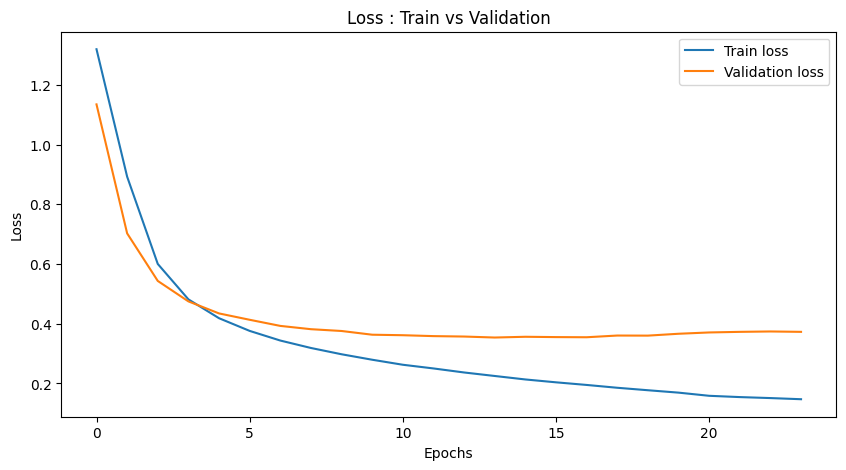

In [21]:
fig = plt.figure(figsize=(10,5))

plt.plot(train_loss_list, label="Train loss")
plt.plot(val_loss_list, label="Validation loss")
plt.title("Loss : Train vs Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()

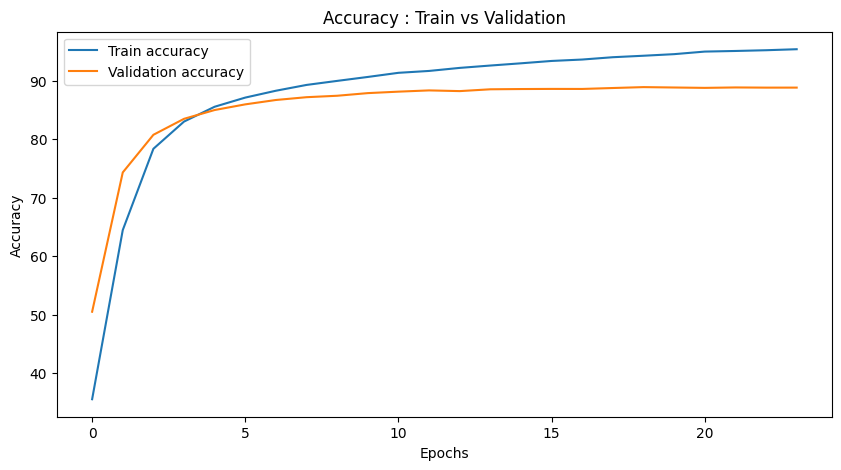

In [22]:
fig = plt.figure(figsize=(10,5))

plt.plot(train_acc_list, label="Train accuracy")
plt.plot(val_acc_list, label="Validation accuracy")
plt.title("Accuracy : Train vs Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

### Testing

In [23]:
def format_test_data(df):
    df['Text'] = (df.Title + " " + df.Description).apply(clean_text)
    df.drop(['Title', 'Description'], axis=1, inplace=True)
    le = LabelEncoder().fit(df['Class Index'])
    df['label'] = le.transform(df['Class Index'])
    test_data = SpamClassificationDataset(df)
    test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, 
                                collate_fn=MyCollate(pad_idx=vocab.tokens_to_idx['<PAD>'], max_len=25))
    return test_dataloader

In [24]:
test_dataloader = format_test_data(df_test)
iterable = iter(test_dataloader)
text, label = iterable.next()
text.shape, label.shape

(torch.Size([1024, 25]), torch.Size([1024]))

In [25]:
with torch.no_grad():
    y_global, y_pred_global = [], []
    test_loss_list, test_acc_list = [], []
    for i, (X_batch, labels) in enumerate(test_dataloader):
        X_batch = X_batch.to(device)
        labels = labels.to(device)
        out = model(X_batch)
        batch_loss = criterion(out, labels)
        test_loss_list.append(batch_loss.item())
        _, y_pred = torch.max(out.data, dim=1)
        test_acc_list.append(torch.sum(y_pred == labels).item() / len(labels))
        y_global.extend(labels.detach().cpu().numpy())
        y_pred_global.extend(y_pred.detach().cpu().numpy())
        
                
    cm = confusion_matrix(y_global, y_pred_global)
    test_loss = np.mean(test_loss_list)
    test_acc = 100 * np.mean(test_acc_list)
    print(f"Test accuracy : {test_acc:.2f}%\t Test Loss : {test_loss:.3f}")
    print(classification_report(y_global, y_pred_global))

Test accuracy : 88.65%	 Test Loss : 0.366
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1900
           1       0.94      0.95      0.94      1900
           2       0.85      0.85      0.85      1900
           3       0.85      0.87      0.86      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600



In [26]:
def plot_heatmap(categories, confusion_matrix):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap=mpl.cm.cividis)
    ax.set_xticks(np.arange(len(categories)), labels=categories)
    ax.set_yticks(np.arange(len(categories)), labels=categories)
    cbar = ax.figure.colorbar(im)
    plt.setp(ax.get_xticklabels(), rotation=90, ha='right', rotation_mode='anchor')
    for i in range(len(confusion_matrix)):
        for j in range(len(confusion_matrix[0])):
            text = ax.text(j, i, cm[i, j], ha='center', va='center', color='grey')
    ax.set_title("Confusion matrix")
    plt.show()

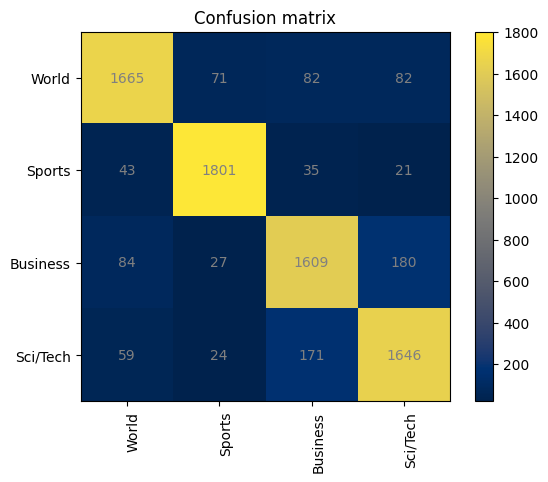

In [27]:
categories = ["World", "Sports", "Business", "Sci/Tech"]
plot_heatmap(categories, cm)